# Experiment 3

Experiment 3 is about to further explore the impact of the hardness of the negative examples on the model.

* [Reducing Data](#Reducing-Data)
* [Training](#Training)
* [Evaluating](#Evaluating)
* [Plots](#Plots)

In [4]:
import sys
sys.path.append('..')

## Reducing Data

> Aimed to solve the 'OutOfMemoryError' but nothing changed.

In [129]:
dataset = irds.load('msmarco-passage/train/triples-small')
BM25_docpairs = pd.read_csv(f'../data/new_docpairs.csv', index_col=False, header=None, names=['query_id', 'doc_id_a', 'doc_id_b'])
true_docpairs = pd.read_csv(f'../data/truenegative_docpairs.csv', index_col=False, header=None, names=['query_id', 'doc_id_a', 'doc_id_b'])

docs = pd.DataFrame(dataset.docs_iter()).set_index('doc_id').text.to_dict()
queries = pd.DataFrame(dataset.queries_iter()).set_index('query_id').text.to_dict()

In [158]:
docids = list(set(BM25_docpairs['doc_id_a'].astype(str).tolist() + BM25_docpairs['doc_id_b'].astype(str).tolist() + true_docpairs['doc_id_b'].astype(str).tolist()))
qids = BM25_docpairs['query_id'].astype(str).tolist()

In [130]:
from tqdm.notebook import tqdm
import numpy as np

reduced_docs = {}

for docid in tqdm(docids):
    reduced_docs[docid] = docs[docid]

  0%|          | 0/265041 [00:00<?, ?it/s]

In [159]:
reduced_queries = {}

for qid in tqdm(qids):
    reduced_queries[qid] = queries[qid]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [161]:
from utils import save_data

save_data(reduced_docs, 'data', 'reduced_docs')
save_data(reduced_queries, 'data', 'reduced_queries')

## Training

In [1]:
%run -i '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3' --batch_size 16 --mode 'BM25-Warm-Up' --fraction 0.25

/home/jht412/anaconda3/envs/py310_20230225/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


  0%|          | 0/100000.0 [00:00<?, ?it/s]

In [6]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3' --mode 'BM25-Warm-Up' --fraction 0.25

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                        | 32/100000.0 [00:03<2:44:56, 10.10it/s, loss=1.11]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|███████████████████▉| 99968/100000.0 [15:52<00:00, 104.99it/s, loss=0.0127]
100%|███████████████████▉| 99968/100000.0 [15:51<00:00, 105.06it/s, loss=0.0127]


In [5]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3' --mode 'BM25-Warm-Up' --fraction 0.75

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                         | 32/100000.0 [00:03<2:46:54,  9.98it/s, loss=1.1]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|███████████████████| 100000/100000.0 [15:45<00:00, 105.76it/s, loss=0.0167]
100%|███████████████████| 100000/100000.0 [15:45<00:00, 105.76it/s, loss=0.0167]


## Evaluating

In [1]:
# Exp 1 with Exp 2 (0.5) and Exp 3 (0.25, 0.75)

%run -i '../evaluate.py' --output_name '20230727' --batch_size 16 --exp 'exp3'

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


02:59:12.188 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.
02:59:13.782 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.


monoT5: 100%|████████████████████████| 12078/12078 [09:23<00:00, 21.44batches/s]


### Plots

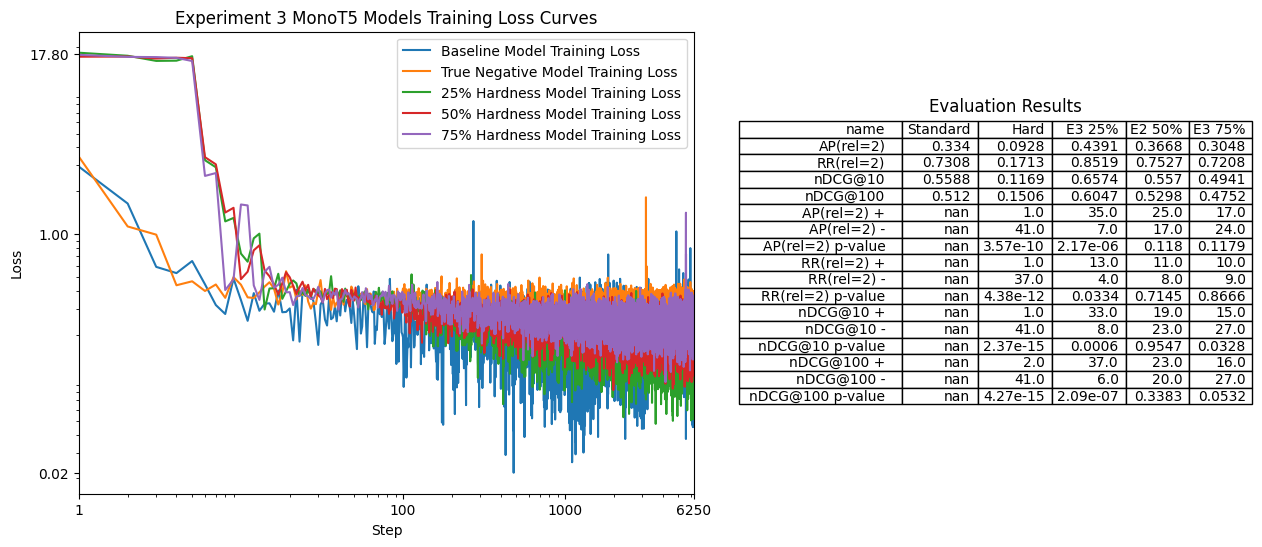

In [80]:
from utils import get_curves

result_df = pd.read_csv(f'results/test-2019_20230727_16-Copy.csv', index_col=0)
logs_paths = [
    '../Experiment_1/model_base', 
    '../Experiment_1/model_new', 
    'model_exp3/model_16_0.25', 
    '../Experiment_2/model_exp2/model_16_0.5', 
    'model_exp3/model_16_0.75'
]
labels = [
    'Baseline Model Training Loss',
    'True Negative Model Training Loss',
    '25% Hardness Model Training Loss',
    '50% Hardness Model Training Loss',
    '75% Hardness Model Training Loss'
]
get_curves(logs_paths, result_df, 'Experiment 3 MonoT5 Models Training', labels)